# openEO use case for floods - UC11

## GFM

The Global Flood Monitoring (GFM) product is a component of the EU’s Copernicus
Emergency Management Service (CEMS) that provides continuous monitoring of
floods worldwide, by processing and analysing in near real-time all
incoming Sentinel-1 SAR acquisitions over land.

The operational implementation the GFM product includes the following key
elements:
- Downloading of worldwide Sentinel-1 SAR acquisitions (Level-1 IW GRDH)
- Pre-processing of the downloaded Sentinel-1 data to backscatter data (SIG0)
- Operational application of three fully automated flood mapping algorithms.
- An ensemble-based approach is then used to combine the three flood extent
  outputs of the individual flood algorithms.
- Generation of the required GFM output layers, including Observed flood extent,
  Reference water mask, Exclusion Mask and Likelihood Values
- Web service-based access and dissemination of the GFM product output layers

### Output layers used in this notebook
- Observed flood extent (ENSEMBLE of all three individual flood outputs)
- Reference water mask (permament and seasonal water bodies)

### Links
https://extwiki.eodc.eu/GFM

### Connect and authenticate to openEO

In [1]:
import openeo
from openeo.processes import *

conn = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


### Describe the GFM collection

In [2]:
conn.describe_collection("GFM")

{'assets': {'thumbnail': {'href': 'https://data.eodc.eu/collections/GFM_ARCHIVE/gfm_collection_thumbnail.png',
   'roles': ['thumbnail'],
   'title': 'GFM collection thumbnail',
   'type': 'iamge/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['advisory_flags',
    'exclusion_mask',
    'ensemble_flood_extent',
    'ensemble_likelihood',
    'ensemble_water_extent',
    'reference_water_mask',
    'dlr_flood_extent',
    'dlr_likelihood',
    'list_flood_extent',
    'list_likelihood',
    'tuw_flood_extent',
    'tuw_likelihood']},
  't': {'extent': [['2015-01-01T00:00:00Z', None]], 'type': 'temporal'},
  'x': {'axis': 'x', 'extent': [-180, 180], 'type': 'spatial'},
  'y': {'axis': 'y', 'extent': [-90, 90], 'type': 'spatial'}},
 'description': "The Global Flood Monitoring (GFM) product is a new component of the EU's Copernicus Emergency Management Service (CEMS) that provides continuous monitoring of floods worldwide, by processing and analysing in near real-time (NRT) all incoming Synthetic Aperture Radar (SAR) imagery acquired by the EU's Copernicus Sentinel-1 satellites, in Interferometric Wide Swath (IW) mode and as Ground Range Detected (GRD) products.",
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2015-01-01T00:00:00Z', None]]}},
 'id': 'GFM',
 'item_assets': {'advisory_flags': {'description': 'GFM advisory flags',
   'roles': ['data'],
   'title': 'GFM advisory flags',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'dlr_flood_extent': {'description': 'GFM observed flood extent (DLR)',
   'roles': ['data'],
   'title': 'GFM observed flood extent (DLR)',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'dlr_likelihood': {'description': 'GFM likelihood (DLR)',
   'roles': ['data'],
   'title': 'GFM likelihood (DLR)',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'ensemble_flood_extent': {'description': 'GFM observed flood extent (ENSEMBLE)',
   'roles': ['data'],
   'title': 'GFM observed flood extent (ENSEMBLE)',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'ensemble_likelihood': {'description': 'GFM likelihood (ENSEMBLE)',
   'roles': ['data'],
   'title': 'GFM likelihood (ENSEMBLE)',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'ensemble_water_extent': {'description': 'GFM observed water extent',
   'roles': ['data'],
   'title': 'GFM observed water extent',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'exclusion_mask': {'description': 'GFM exclusion mask',
   'roles': ['data'],
   'title': 'GFM exclusion mask',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'list_flood_extent': {'description': 'GFM observed flood extent (LIST)',
   'roles': ['data'],
   'title': 'GFM observed flood extent (LIST)',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'list_likelihood': {'description': 'GFM likelihood (LIST)',
   'roles': ['data'],
   'title': 'GFM likelihood (LIST)',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'reference_water_mask': {'description': 'GFM reference water mask',
   'roles': ['data'],
   'title': 'GFM reference water mask',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'tuw_flood_extent': {'description': 'GFM observed flood extent (TUW)',
   'roles': ['data'],
   'title': 'GFM observed flood extent (TUW)',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'},
  'tuw_likelihood': {'description': 'GFM likelihood (TUW)',
   'roles': ['data'],
   'title': 'GFM likelihood (TUW)',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}},
 'keywords': ['sentinel', 'copernicus', 'esa', 'jrc', 'flood'],
 'license': 'proprietary',
 'links': [{'href': 'https://stac.eodc.eu/api/v1/collections/GFM/items',
   'rel': 'items',
   'type': 'application/geo+jso

### Temporal sum of flooded pixels

In this example, we have a closer look at an area in Pakistan, which was revaged by the unprecedented floods of 2022. The flooding caused severe damage and economic losses and is referred to as the worst flood in the history of Pakistan. 
We compute the sum of flooded pixels over time.

In [3]:
spatial_extent  = {'west': 67.5, 'east': 70, 'south': 24.5, 'north': 26}
temporal_extent = ["2022-09-01", "2022-10-01"] 
collection      = 'GFM'

gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["ensemble_flood_extent"]
)
gfm_sum = gfm_data.reduce_dimension(dimension="t", reducer=sum)

gfm_sum_tiff = gfm_sum.save_result(format="GTiff", options={"tile_grid": "wgs84-1degree"})

In [4]:
job = gfm_sum_tiff.create_job(title = "UC11").start_job()

In [5]:
job.status()

'finished'

In [6]:
job.get_results().download_files("./gfm/flood_extent_wgs/")

[PosixPath('gfm/flood_extent_wgs/WGS84_E67N23_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E67N24_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E67N25_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E67N26_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E68N23_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E68N24_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E68N25_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E68N26_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E69N23_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E69N24_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E69N25_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E69N26_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E70N23_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/WGS84_E70N24_20220901T010907.tif'),
 PosixPath('gfm/flood_extent_wgs/W

### Load the downloaded result files

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [8]:
path = "./gfm/flood_extent_wgs/WGS84_E69N25_20220901T010907.tif"
flood_extent = xr.open_dataset(path).band_data

### Explore how the flood extent relates to the Global Human Settlement Built-up layer

We display the flood extent next to the Global Human Settlement Built-up layer.

The Global Human Settlement Layer (GHSL) project produces global spatial 
information about the human presence on the planet over time in the form of 
built-up maps, population density maps and settlement maps.

Here, the GHS-BUILT-S spatial raster dataset at 10m resolution is used which 
depicts the distribution of built-up surfaces, expressed as number of square metres.

Values are between 0 and 100 and represent the amount of square metres of
built-up surface in the cell. 

The data can also be downloaded from: https://ghsl.jrc.ec.europa.eu/about.php

In [66]:
import s3fs
import xarray as xr
S3_URL_CENTRAL = "https://s3.central.data.destination-earth.eu"
s3_central = s3fs.S3FileSystem(
    anon=True,
    use_ssl=True,
    client_kwargs={"endpoint_url": S3_URL_CENTRAL},
)
ghsl = xr.open_zarr(store=s3fs.S3Map(
    root="increment1-testdata/built_data.zarr", 
    s3=s3_central, 
    check=False),
    decode_coords="all"
)
display(ghsl.built)

min_lat, max_lat = 25.1, 25.2
min_lon, max_lon = 69.1, 69.2

ghsl = ghsl.built.sel(x=slice(min_lon, max_lon), y=slice(max_lat, min_lat))
display(ghsl)

<xarray.DataArray 'built' (y: 68116, x: 112644)>
dask.array<open_dataset-built, shape=(68116, 112644), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 ...
    spatial_ref  int64 ...
  * x            (x) float64 64.02 64.02 64.02 64.02 ... 73.03 73.03 73.03 73.03
  * y            (y) float64 30.0 30.0 30.0 30.0 ... 24.55 24.55 24.55 24.55
Attributes:
    AREA_OR_POINT:  Area

<xarray.DataArray 'built' (y: 1251, x: 1251)>
dask.array<getitem, shape=(1251, 1251), dtype=float32, chunksize=(980, 779), chunktype=numpy.ndarray>
Coordinates:
    band         int64 ...
    spatial_ref  int64 ...
  * x            (x) float64 69.1 69.1 69.1 69.1 69.1 ... 69.2 69.2 69.2 69.2
  * y            (y) float64 25.2 25.2 25.2 25.2 25.2 ... 25.1 25.1 25.1 25.1
Attributes:
    AREA_OR_POINT:  Area

In [9]:
# The above-mentioned GHSL data is also available for the region of interest as
# NetCDF in this repository
ghsl = xr.open_dataset("./../ghsl.nc")
display(ghsl)

<xarray.Dataset>
Dimensions:      (x: 1251, y: 1251)
Coordinates:
    band         int64 ...
  * x            (x) float64 69.1 69.1 69.1 69.1 69.1 ... 69.2 69.2 69.2 69.2
  * y            (y) float64 25.2 25.2 25.2 25.2 25.2 ... 25.1 25.1 25.1 25.1
Data variables:
    spatial_ref  int64 ...
    built        (y, x) float32 ...

In [10]:
min_lat, max_lat = np.min(ghsl.y.values), np.max(ghsl.y.values)
min_lon, max_lon = np.min(ghsl.x.values), np.max(ghsl.x.values)

flood_extent = flood_extent.sel(x=slice(min_lon, max_lon), y=slice(max_lat, min_lat), band=1)
flood_extent = xr.where(flood_extent == 0, np.nan, flood_extent)
display(flood_extent)

<xarray.DataArray 'band_data' (y: 556, x: 555)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 69.1 69.1 69.1 69.1 69.1 ... 69.2 69.2 69.2 69.2
  * y            (y) float64 25.2 25.2 25.2 25.2 25.2 ... 25.1 25.1 25.1 25.1
    spatial_ref  int64 0

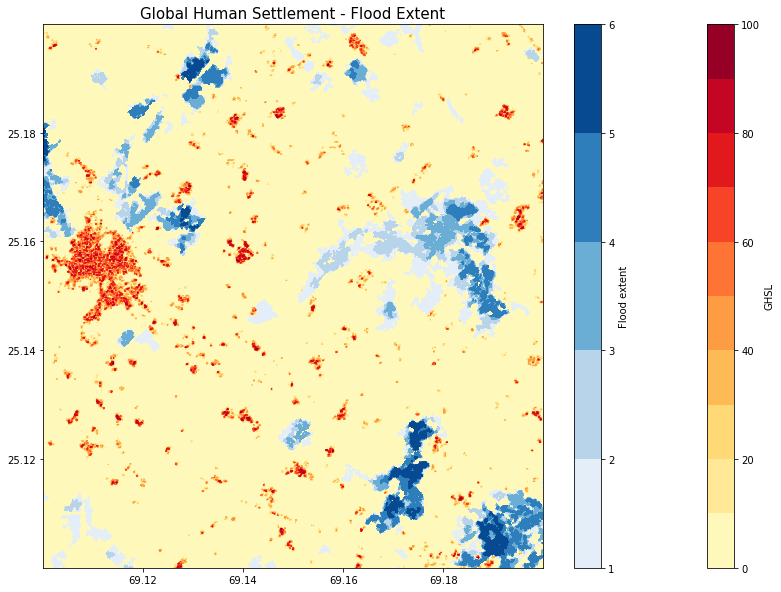

In [11]:
plt.figure(figsize=(14,10))
plt.title("Global Human Settlement - Flood Extent", fontsize=15)
X, Y = np.meshgrid(ghsl.x.values, ghsl.y.values)
g = plt.contourf(X, Y, ghsl.built,cmap='YlOrRd', levels=10)
plt.colorbar(label="GHSL")
X, Y = np.meshgrid(flood_extent.x.values, flood_extent.y.values)
f = plt.contourf(X, Y, flood_extent,cmap='Blues', levels=5)
plt.colorbar(label="Flood extent")

Estimate of how the built-up surface was effected by the flood in Pakistan in September 2022. Some of the highest values of the GHSL can be found around 25.16 N 69.11 E, which marks Digri Tehsil, the second largest town of Mirpurkhas District, Pakistan.

### Observed water (flood_extent + refwater)

The observed water combines both flood extent and the reference water mask. The reference water mask represents permanent or seasonal water bodies, which are clearly distinct from flood events.

In [12]:
spatial_extent  = {'west': 67.5, 'east': 70, 'south': 24.5, 'north': 26}
temporal_extent = ["2022-09-01", "2022-10-01"] 
collection      = 'GFM'

gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["ensemble_flood_extent", "reference_water_mask"]
)

# retrieve all pixels which have been detected as water during the given period
# -> observed water
observed_water = gfm_data.reduce_dimension(dimension="bands", reducer=any).reduce_dimension(dimension="t", reducer=any)

# Save the result in Equi7Grid and as GeoTiff
observed_water_tif = observed_water.save_result(format="GTiff", options={"tile_grid": "equi7"})

openEO allows us to choose a tile grid, which matches the coordinate reference system. The original crs of the dataset is the Equi7, so we store our results accordingly. 

In [13]:
job = observed_water_tif.create_job(title = "UC11").start_job()

In [14]:
job.status()

'finished'

In [15]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./gfm/observed_water/")

[PosixPath('gfm/observed_water/AS020M_E015N024T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/AS020M_E015N027T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/AS020M_E018N024T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/AS020M_E018N027T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/job-results.json')]

In [16]:
path = "./gfm/observed_water/"
files = [path + file for file in os.listdir(path) if file.startswith("AS")]
# we expect only 0 and 1 -> bool
data = xr.open_mfdataset(files).band_data.astype("bool")
data

<xarray.DataArray 'band_data' (band: 1, y: 11879, x: 14489)>
dask.array<astype, shape=(1, 11879, 14489), dtype=bool, chunksize=(1, 9506, 8967), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.621e+06 1.621e+06 1.621e+06 ... 1.91e+06 1.91e+06
  * y            (y) float64 2.89e+06 2.89e+06 2.89e+06 ... 2.653e+06 2.653e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:                 Area
    filepaths:                     []
    gfm:                           https://extwiki.eodc.eu/GFM
    snapshot_STAC_collection_URL:  https://stac.eodc.eu/api/v1/collections/GFM
    long_name:                     band_data

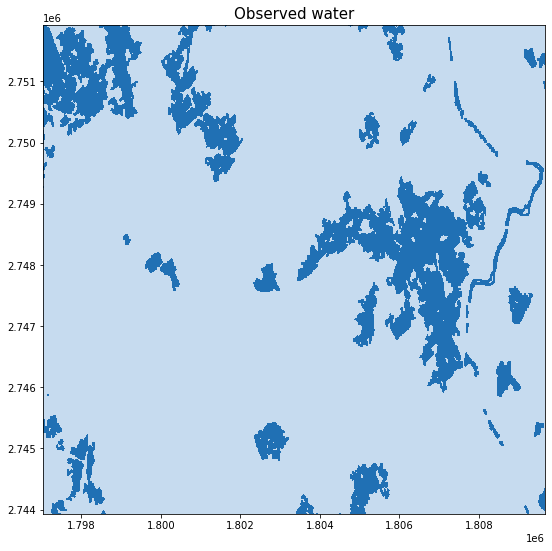

In [17]:
plt.figure(figsize=(9,9))
plt.title("Observed water", fontsize=15)
d_small = data.sel(band=1, x=slice(1797025,1809688), y=slice(2751932,2743913))
X, Y = np.meshgrid(d_small.x.values, d_small.y.values)
plt.contourf(X, Y, d_small, cmap='Blues')